In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK, Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Quantile_Lorentzian as Q_Lorentzian
from tqdm.notebook import tqdm
import parmap

In [34]:
# === Optimized EKF for Kuramoto + K tracking (single script) ===
import numpy as np

# ---- (optional) numba JIT ---------------------------------------------------
try:
    from numba import njit
except Exception:
    def njit(*args, **kwargs):
        def deco(fn): return fn
        return deco

# ---- angle & order helpers ---------------------------------------------------
@njit(fastmath=True, cache=True)
def _wrap_angle_scalar(a):
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v/(2.0*np.pi))
    return v - np.pi

@njit(fastmath=True, cache=True)
def _order_params(T):
    csum = 0.0
    ssum = 0.0
    N = T.size
    for i in range(N):
        csum += np.cos(T[i])
        ssum += np.sin(T[i])
    invN = 1.0 / N
    return csum*invN, ssum*invN  # X, Y

# ---- models (JIT) ------------------------------------------------------------
@njit(fastmath=True, cache=True)
def f_fast_jit(x, omega, dt):
    """x=[theta..., K]; dθ = ω + K (Y cosθ - X sinθ)"""
    N = omega.size
    T = x[:N]
    K = x[N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    dtheta = omega + K*(Y*c - X*s)
    Tn = T + dt*dtheta
    for i in range(N):
        Tn[i] = _wrap_angle_scalar(Tn[i])
    out = np.empty_like(x)
    out[:N] = Tn
    out[N]  = K
    return out

@njit(fastmath=True, cache=True)
def H_j_jit(x):
    """H = dR/dx, shape (1, N+1); dR/dK=0"""
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    R = np.hypot(X, Y)
    H = np.zeros((1, N+1))
    if R > 1e-12:
        H[0, :N] = (-X*s + Y*c) / (N * R)
    return H

@njit(fastmath=True, cache=True)
def h_jit(x):
    """z = R = |(1/N)Σ e^{iθ}|"""
    N = x.size - 1
    T = x[:N]
    X = np.mean(np.cos(T)); Y = np.mean(np.sin(T))
    return np.array([np.hypot(X, Y)])

@njit(fastmath=True, cache=True)
def F_Kcol_jit(x, dt):
    """∂x_next/∂K column for sensitivity (no full F needed)."""
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    col = np.empty(N+1)
    col[:N] = dt*(Y*c - X*s)  # dT'/dK
    col[N]  = 1.0             # dK'/dK
    return col

# ---- fast predict: P_bar = F P F^T via rank-2 structure ----------------------
def predict_cov_rank2(P, x_bar, dt, Q):
    """
    Compute P_bar = F P F^T + Q without forming F.
    Uses F_theta,theta = diag(d) + α (c c^T + s s^T), and dT/dK = b.
    Works best when Q has only K-noise; still correct for general Q by +Q at end.
    """
    n = P.shape[0]; N = n - 1
    T = x_bar[:N]; Kval = x_bar[-1]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)

    alpha = dt * Kval / N
    d = 1.0 - dt*Kval*(X*c + Y*s)     # (N,)
    b = dt*(Y*c - X*s)                 # (N,)

    Ptt = P[:N, :N]
    Ptk = P[:N, -1]
    Pkk = P[-1, -1]

    vc = Ptt @ c
    vs = Ptt @ s
    ScC = float(c @ vc)                # c^T P c
    SsS = float(s @ vs)                # s^T P s
    ScS = float(c @ vs)                # c^T P s

    # A P A^T on θ-θ block
    DP  = d[:, None] * Ptt
    DPD = DP * d[None, :]

    w1 = (d * vc)[:, None] @ c[None, :]
    w2 = (d * vs)[:, None] @ s[None, :]
    u1 = c[:, None] @ ((vc * d)[None, :])
    u2 = s[:, None] @ ((vs * d)[None, :])

    term_cc = ScC * (c[:, None] @ c[None, :])
    term_ss = SsS * (s[:, None] @ s[None, :])
    term_cs = ScS * (c[:, None] @ s[None, :] + s[:, None] @ c[None, :])

    A_P_A = DPD + alpha*(w1 + w2 + u1 + u2) + (alpha**2)*(term_cc + term_ss + term_cs)

    # cross terms with K
    cp = float(c @ Ptk); sp = float(s @ Ptk)
    Ap = d * Ptk + alpha*(cp*c + sp*s)            # A p_{θK}
    A_P_A += Ap[:, None] @ b[None, :] + b[:, None] @ Ap[None, :] + Pkk * (b[:, None] @ b[None, :])

    # assemble full P_bar
    P_bar = np.empty_like(P)
    top_right = Ap + Pkk * b
    P_bar[:N, :N] = A_P_A
    P_bar[:N, -1] = top_right
    P_bar[-1, :N] = top_right
    P_bar[-1, -1] = Pkk

    # add process noise
    P_bar += Q
    return P_bar

# ==== EKF loop (rank-1 Joseph, freeze/unfreeze, periodic PSD floor) ===========
def run_ekf_rank1_fast(theta_random, K_init, omega, t, rs,
                       R_meas=1e-10, Q_K=1e-8,
                       epsP=1e-12, epsS=1e-10, jitterP=1e-8,
                       sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
                       sens_tol=1e-4, W=50, eig_every=20):
    N = theta_random.size
    dt = float(t[1]-t[0]) if len(t) > 1 else 1.0
    n = N + 1

    # init state & cov
    x = np.r_[theta_random, float(K_init)].astype(float)
    x[:N] = (x[:N] + np.pi) % (2*np.pi) - np.pi
    P = np.eye(n) * 1e-6
    P[-1, -1] = 1e-4  # K init variance (optional tuning)

    Q = np.zeros((n, n)); Q[-1, -1] = Q_K

    Tn = len(t)
    x_hats = np.zeros((Tn, n))
    P_hats = np.zeros((Tn, n, n))
    z_hats = np.zeros(Tn)
    S_s    = np.zeros(Tn)

    x_hats[0] = x
    P_hats[0] = P
    z_hats[0] = h_jit(x)[0]

    freeze = False
    nis_hist = []

    for i in range(1, Tn):
        z_meas = float(np.clip(rs[i] + np.random.randn()*np.sqrt(R_meas), 1e-9, 1.0))

        # ---- predict (state) ----
        x_bar = f_fast_jit(x, omega, dt)

        # ---- predict (cov) : fast rank-2 ----
        P_bar = predict_cov_rank2(P, x_bar, dt, Q)
        P_bar += np.eye(n) * jitterP
        P_bar = 0.5 * (P_bar + P_bar.T)

        # ---- measurement prediction ----
        H = H_j_jit(x_bar)             # (1, n)
        z_bar = float(h_jit(x_bar)[0])
        v = P_bar @ H.T                # (n, 1)
        S = float(H @ v + R_meas)      # scalar
        if S < epsS: S = epsS
        S_s[i] = S

        # ---- gain & innovation ----
        K_gain = v / S                  # (n,1)
        nu = float(z_meas - z_bar)

        # ---- freeze logic (P_KK small + NIS normal + sensitivity small) ----
        q = (nu*nu)/S
        nis_hist.append(q)
        if len(nis_hist) > W: nis_hist.pop(0)
        q_mean = float(np.mean(nis_hist))

        F_Kcol = F_Kcol_jit(x_bar, dt) # (n,)
        sK = float(H @ F_Kcol.reshape(-1,1))

        if not freeze:
            if (P_bar[-1, -1] < sigmaK_tol) and (NIS_low <= q_mean <= NIS_high) and (abs(sK) < sens_tol):
                freeze = True
        else:
            if (q_mean > NIS_high) or (abs(sK) >= sens_tol):
                freeze = False

        if freeze:
            K_gain[-1, 0] = 0.0

        # ---- state update ----
        x_hat = x_bar + (K_gain[:, 0] * nu)
        x_hat[:N] = (x_hat[:N] + np.pi) % (2*np.pi) - np.pi
        x_hat[-1] = np.clip(x_hat[-1], 1e-3, 10.0)

        # ---- covariance update (rank-1 Joseph-equivalent) ----
        # P_hat = P_bar - (v v^T) / S, where v = P_bar H^T
        P_hat = P_bar - (v @ v.T) / S
        P_hat = 0.5 * (P_hat + P_hat.T)

        # ---- periodic PSD floor ----
        if (i % eig_every) == 0:
            w, V = np.linalg.eigh(P_hat)
            if w.min() < epsP:
                w = np.maximum(w, epsP)
                P_hat = V @ (w[:, None] * V.T)

        # roll
        x, P = x_hat, P_hat
        x_hats[i] = x
        P_hats[i] = P
        z_hats[i] = z_bar

    return x_hats, P_hats, z_hats, S_s

# ===================== USAGE EXAMPLE =====================
# 준비물: theta_random(N,), K (초기 K 추정), omega(N,), t(T,), rs(T,)
# x_hats, P_hats, z_hats, S_s = run_ekf_rank1_fast(
#     theta_random=theta_random,
#     K_init=K + 2.0,
#     omega=omega,
#     t=t,
#     rs=rs,
#     R_meas=1e-10,
#     Q_K=1e-8,
#     epsP=1e-12, epsS=1e-10, jitterP=1e-8,
#     sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
#     sens_tol=1e-4, W=50, eig_every=20
# )
# K_est = x_hats[:, -1]
# R_pred = z_hats


In [142]:
from numba import njit
import numpy as np

# (-pi,pi] 래핑
@njit(fastmath=True, cache=True)
def _wrap_angle_scalar(a):
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v/(2.0*np.pi))
    return v - np.pi

@njit(fastmath=True, cache=True)
def f_fast_jit(x, omega, dt):
    N = omega.size
    T = x[:N]
    K = x[N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    dtheta = omega + K*(Y*c - X*s)
    T_new = T + dt*dtheta
    for i in range(N):
        T_new[i] = _wrap_angle_scalar(T_new[i])
    out = np.empty_like(x)
    out[:N] = T_new
    out[N] = K
    return out

@njit(fastmath=True, cache=True)
def H_j_jit(x):
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    R = np.hypot(X, Y)
    H = np.zeros((1, N+1))
    if R > 1e-12:
        H[0, :N] = (-X*s + Y*c) / (N*R)
    return H

@njit(fastmath=True, cache=True)
def h_jit(x):
    N = x.size - 1
    T = x[:N]
    X = np.mean(np.cos(T)); Y = np.mean(np.sin(T))
    return np.array([np.hypot(X, Y)])

# d x_next / dK (K-컬럼만 뽑아서 민감도에 사용)
@njit(fastmath=True, cache=True)
def F_Kcol_jit(x, dt):
    N = x.size - 1
    T = x[:N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    col = np.empty(N+1)
    col[:N] = dt*(Y*c - X*s)
    col[N]  = 1.0
    return col

# (선택) F_j를 전체 만들고 싶다면 — 기존 F_j_fast의 JIT 버전
@njit(fastmath=True, cache=True)
def F_j_fast_jit(x, dt):
    N = x.size - 1
    T = x[:N]; K = x[N]
    c = np.cos(T); s = np.sin(T)
    X = np.mean(c); Y = np.mean(s)
    F = np.zeros((N+1, N+1))
    # rank-2 부분
    alpha = dt*K/N
    F[:N, :N] += alpha*(np.outer(c, c) + np.outer(s, s))
    # 대각 수정
    diag = 1.0 - dt*K*(X*c + Y*s)
    for i in range(N):
        F[i, i] += diag[i]
    # dT'/dK
    F[:N, N] = dt*(Y*c - X*s)
    # dK'/dK = 1
    F[N, N] = 1.0
    return F



import numpy as np

def run_ekf_rank1_orig(theta_random, K_init, omega, t, rs,
                       R_meas=1e-10,
                       jitterP=1e-5,     # P_bar 정칙화 (네 코드와 동일)
                       s_floor=1e-6,     # S 하한 (네 코드와 동일)
                       P_floor=1e-12,    # P_hat 요소 바닥 (네 코드와 동일)
                       delta_K_init=2.0, # 초기 K 오프셋: K_init + 2
                       add_meas_noise=True):
    """
    원본 루프를 함수로 감싼 버전 (네 코드와 '동일 동작' 목표)
    - F @ P @ F^T + Q 사용 (predict_cov_rank2 안 씀)
    - Joseph 동등식/랭크-1 다운데이트 안 씀 (네 코드와 동일)
    - S를 1x1 행렬로 두고 inv(S) 사용 (네 코드와 동일)
    - Freeze/민감도/PSD 플로어 없음 (네 코드와 동일)
    """
    N = theta_random.size
    n = N + 1
    dt = float(t[1] - t[0]) if len(t) > 1 else 1.0

    # 초기 상태: [theta..., K_init + 2]  (네 코드와 동일한 오프셋)
    x = np.r_[theta_random, float(K_init + delta_K_init)].astype(float)

    # 공정잡음 Q: 마지막에 np.eye(n)*1e-8 로 덮는 패턴을 '그대로' 반영
    Q = np.eye(n) * 0#1e-8

    # 초기 공분산 P: diag=1e-6, K-분산만 1e-4 (네 코드)
    P = np.eye(n) * 1e-6
    P[-1, -1] = 1e-8

    # 로그/결과 버퍼
    Tn = len(t)
    P_hats = np.zeros((Tn, n, n))
    x_hats = np.zeros((Tn, n))
    z_hats = np.zeros(Tn)
    S_s    = np.zeros(Tn)
    K_gains = []

    # 초기 기록
    x_hats[0] = x
    P_hats[0] = P
    z_hats[0] = float(h_jit(x)[0])  # h(x)[0]과 동일 의미

    for i in range(1, Tn):
        # --- 측정 생성 ---
        z_meas = float(rs[i])
        if add_meas_noise:
            z_meas += float(np.random.randn() * np.sqrt(R_meas))
        z_meas = float(np.clip(z_meas, 1e-6, 1.0))  # 네 코드: 하한 1e-6

        # --- 예측 단계 ---
        x_bar = f_fast_jit(x, omega, dt)           # 상태 예측
        F_bar = F_j_fast_jit(x_bar, dt)            # 야코비안
        P_bar = F_bar @ P @ F_bar.T + Q            # 공분산 예측
        P_bar += np.eye(n) * jitterP               # 정칙화(네 코드와 동일)

        # --- 관측 예측 ---
        H = H_j_jit(x_bar)                         # (1, n)
        z_bar = h_jit(x_bar)                       # (1,)
        S = H @ P_bar @ H.T + R_meas               # (1,1)
        S = np.where(S < s_floor, s_floor, S)      # (1,1) 유지
        S_s[i] = float(S)                          # 스칼라 로그

        # --- 칼만 이득 ---
        K_gain = P_bar @ H.T @ np.linalg.inv(S)    # (n,1)
        K_gains.append(K_gain.copy())

        # --- 상태 업데이트 ---
        # (n,1) @ (1,) -> (n,), 네 코드와 동일 브로드캐스트
        x_hat = x_bar + (K_gain @ (z_meas - z_bar)).ravel()
        x_hat[-1] = np.clip(x_hat[-1], 1e-3, 10.0) # K 범위 보호 (네 코드)

        # --- 공분산 업데이트 (simple, Joseph 아님) ---
        P_hat = P_bar - K_gain @ S @ K_gain.T

        # 요소별 바닥 (네 코드와 동일)
        P_hat = np.where(P_hat < P_floor, P_floor, P_hat)

        # 롤오버
        x = x_hat
        P = P_hat
        x_hats[i] = x
        P_hats[i] = P
        z_hats[i] = float(z_bar[0])

    return x_hats, P_hats, z_hats, S_s, K_gains


In [147]:
seed = None
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)
K = 1.2
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [143]:
x_hats, P_hats, z_hats, S_s,_ = run_ekf_rank1_orig(
    theta_random, 
    K_init=K + 1.0,
    omega=omega,
    t=t,
    rs=rs,
    R_meas=1e-5,
    jitterP=1e-5,     # P_bar 정칙화 (네 코드와 동일)
    s_floor=1e-6,     # S 하한 (네 코드와 동일)
    P_floor=1e-12,    # P_hat 요소 바닥 (네 코드와 동일)
    delta_K_init=2.0, # 초기 K 오프셋: K_init + 2
    add_meas_noise=True)

K_est_orig = x_hats[:, -1]
R_pred_orig = z_hats
print(np.mean(np.abs(K_est_orig - K)[-100:]))


/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/3945293687.py:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] = float(S)                          # 스칼라 로그


0.016660607081727098


In [117]:
x_hats, P_hats, z_hats, S_s = run_ekf_rank1_fast(
    theta_random=theta_random,
    K_init=K + 2.0,
    omega=omega,
    t=t,
    rs=rs,
    R_meas=1e-5,
    Q_K=1e-8,
    epsP=1e-12, epsS=1e-10, jitterP=1e-8,
    sigmaK_tol=1e-4, NIS_low=0.3, NIS_high=3.0,
    sens_tol=1e-4, W=50, eig_every=20
)
K_est = x_hats[:, -1]
R_pred = z_hats
print(np.mean(np.abs(K_est - K)[-100:]))

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/807902518.py:185: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H @ v + R_meas)      # scalar
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/807902518.py:200: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sK = float(H @ F_Kcol.reshape(-1,1))


0.018528003156959544


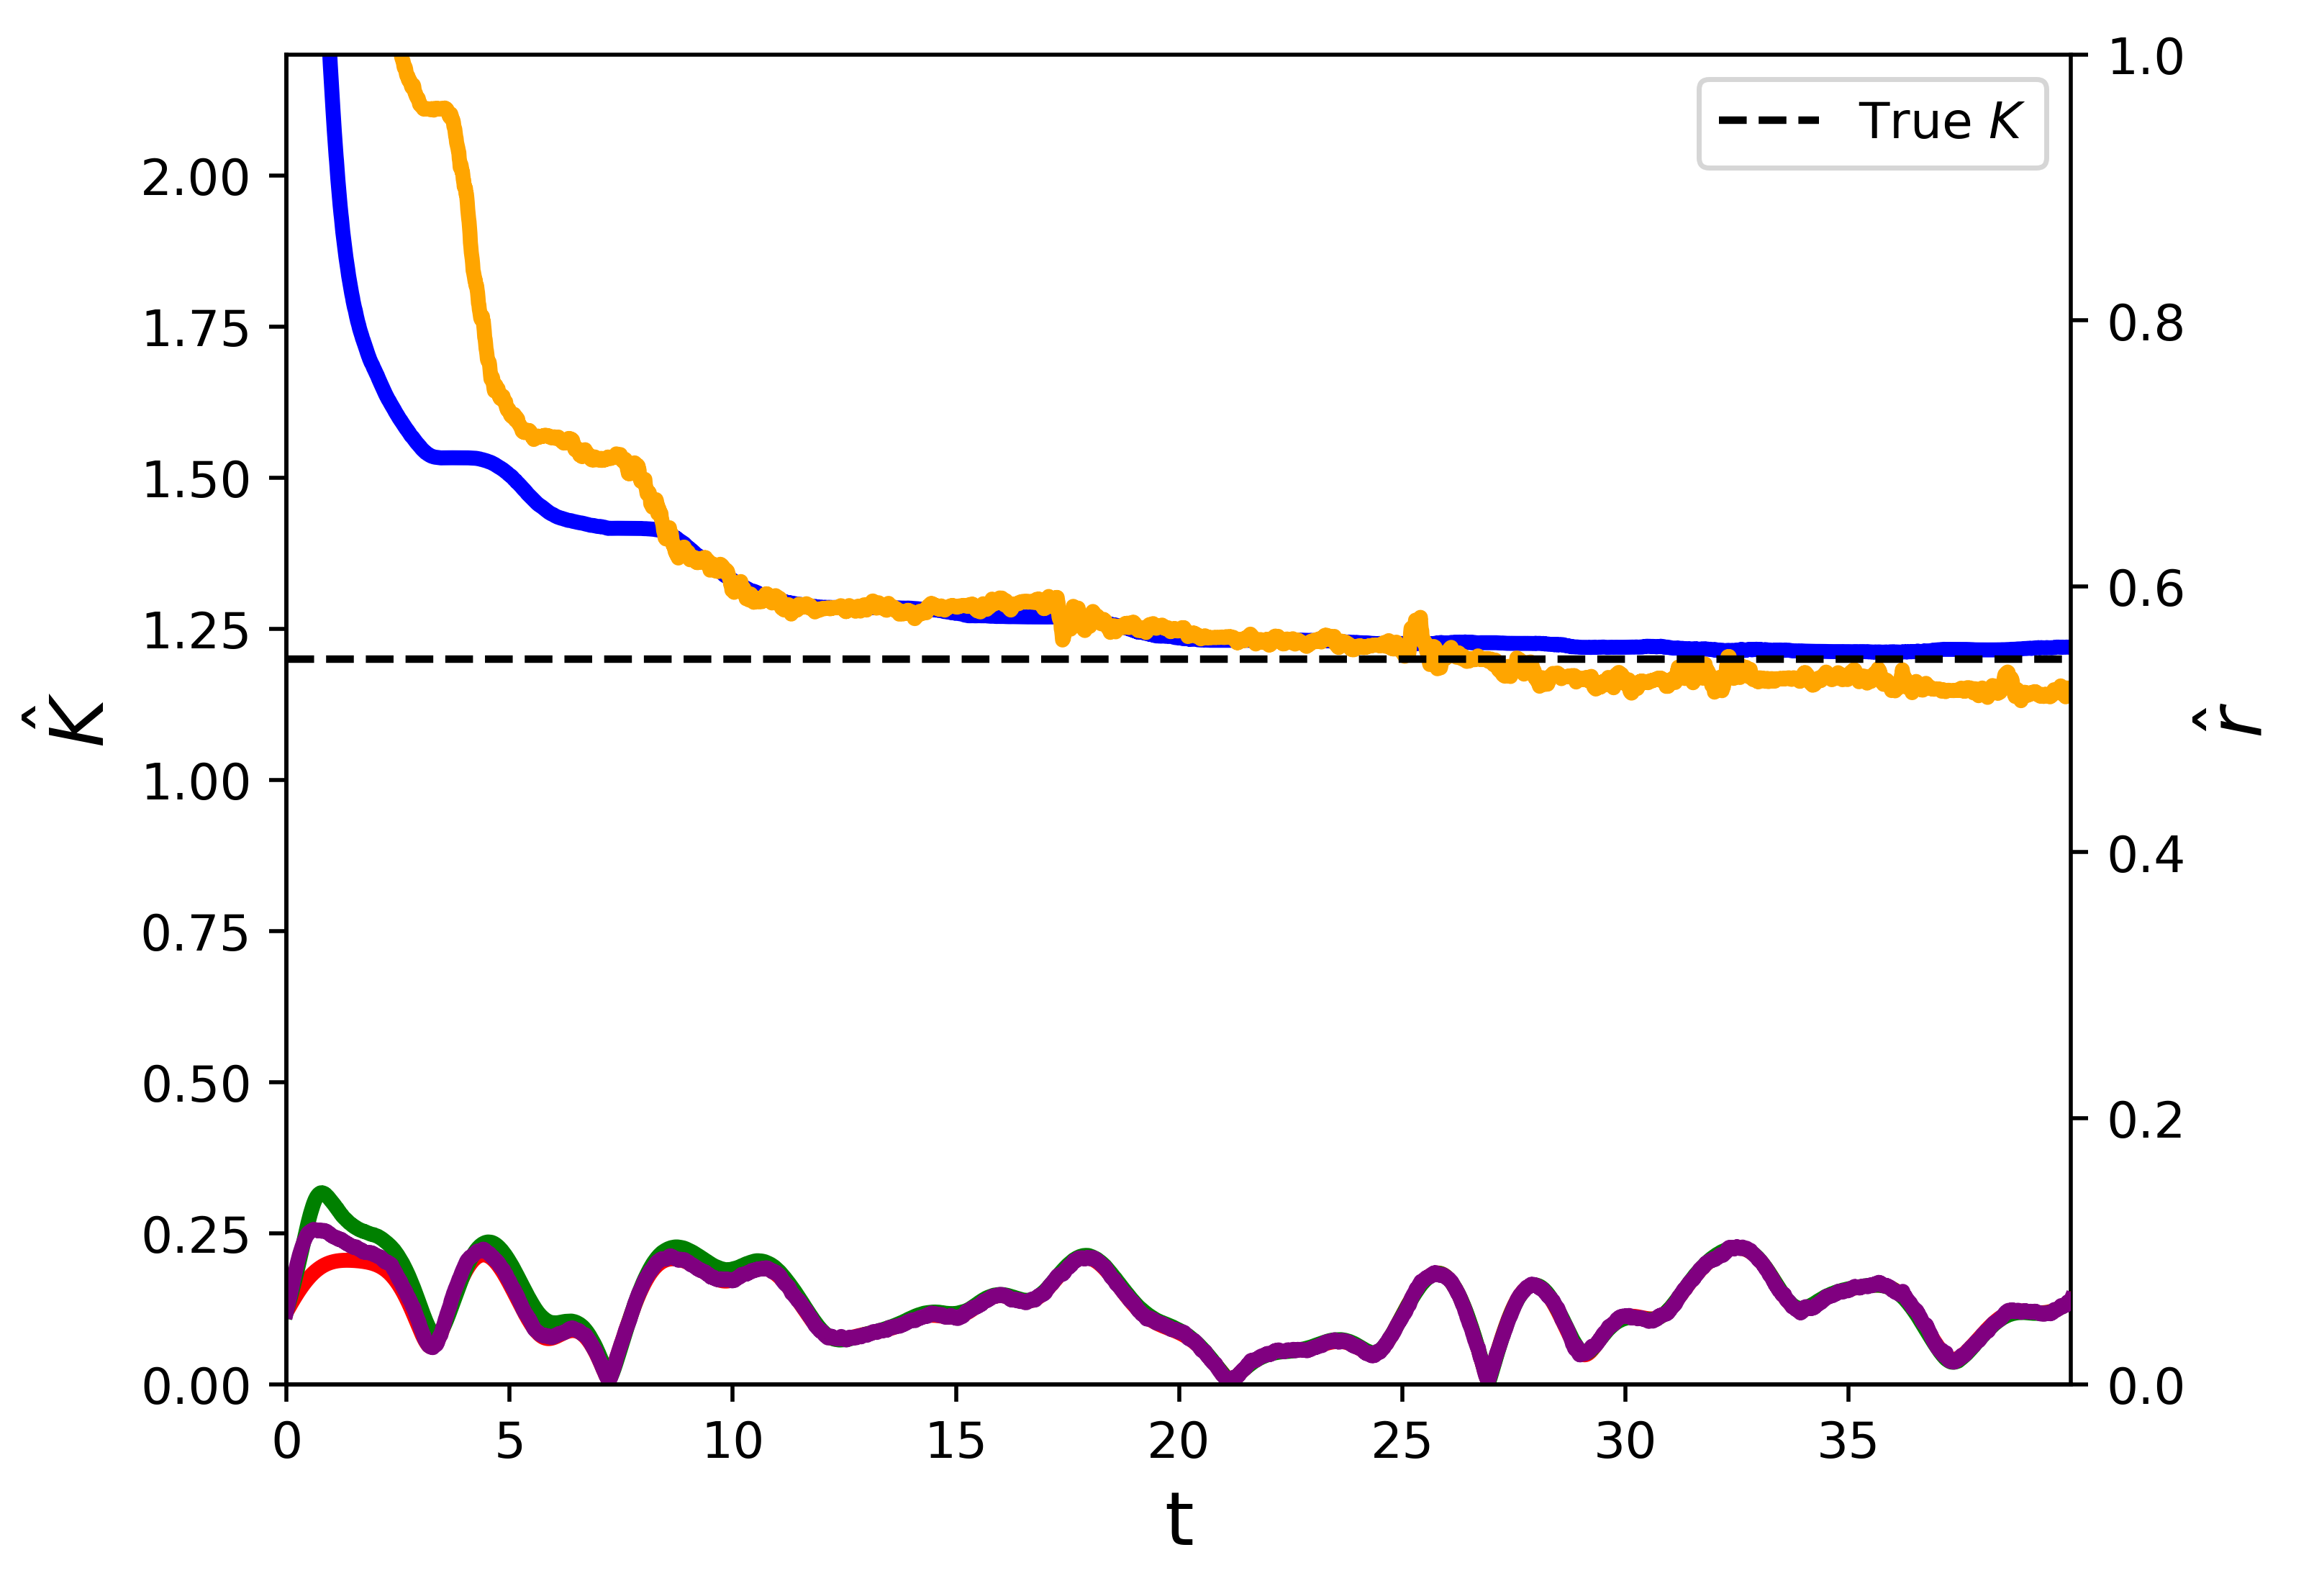

In [118]:
plt.figure(dpi=500)
plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est_orig,color='orange',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,R_pred,color='green',lw=3)
plt.plot(t,R_pred_orig,color='purple',lw=3)
plt.ylabel(r'$\hat{r}$',fontsize=15)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/2518740544.py:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] = float(S)                          # 스칼라 로그
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/2518740544.py:154: RuntimeWarning: overflow encountered in matmul
  P_hat = P_bar - K_gain @ S @ K_gain.T
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/2518740544.py:134: RuntimeWarning: invalid value encountered in matmul
  P_bar = F_bar @ P @ F_bar.T + Q            # 공분산 예측


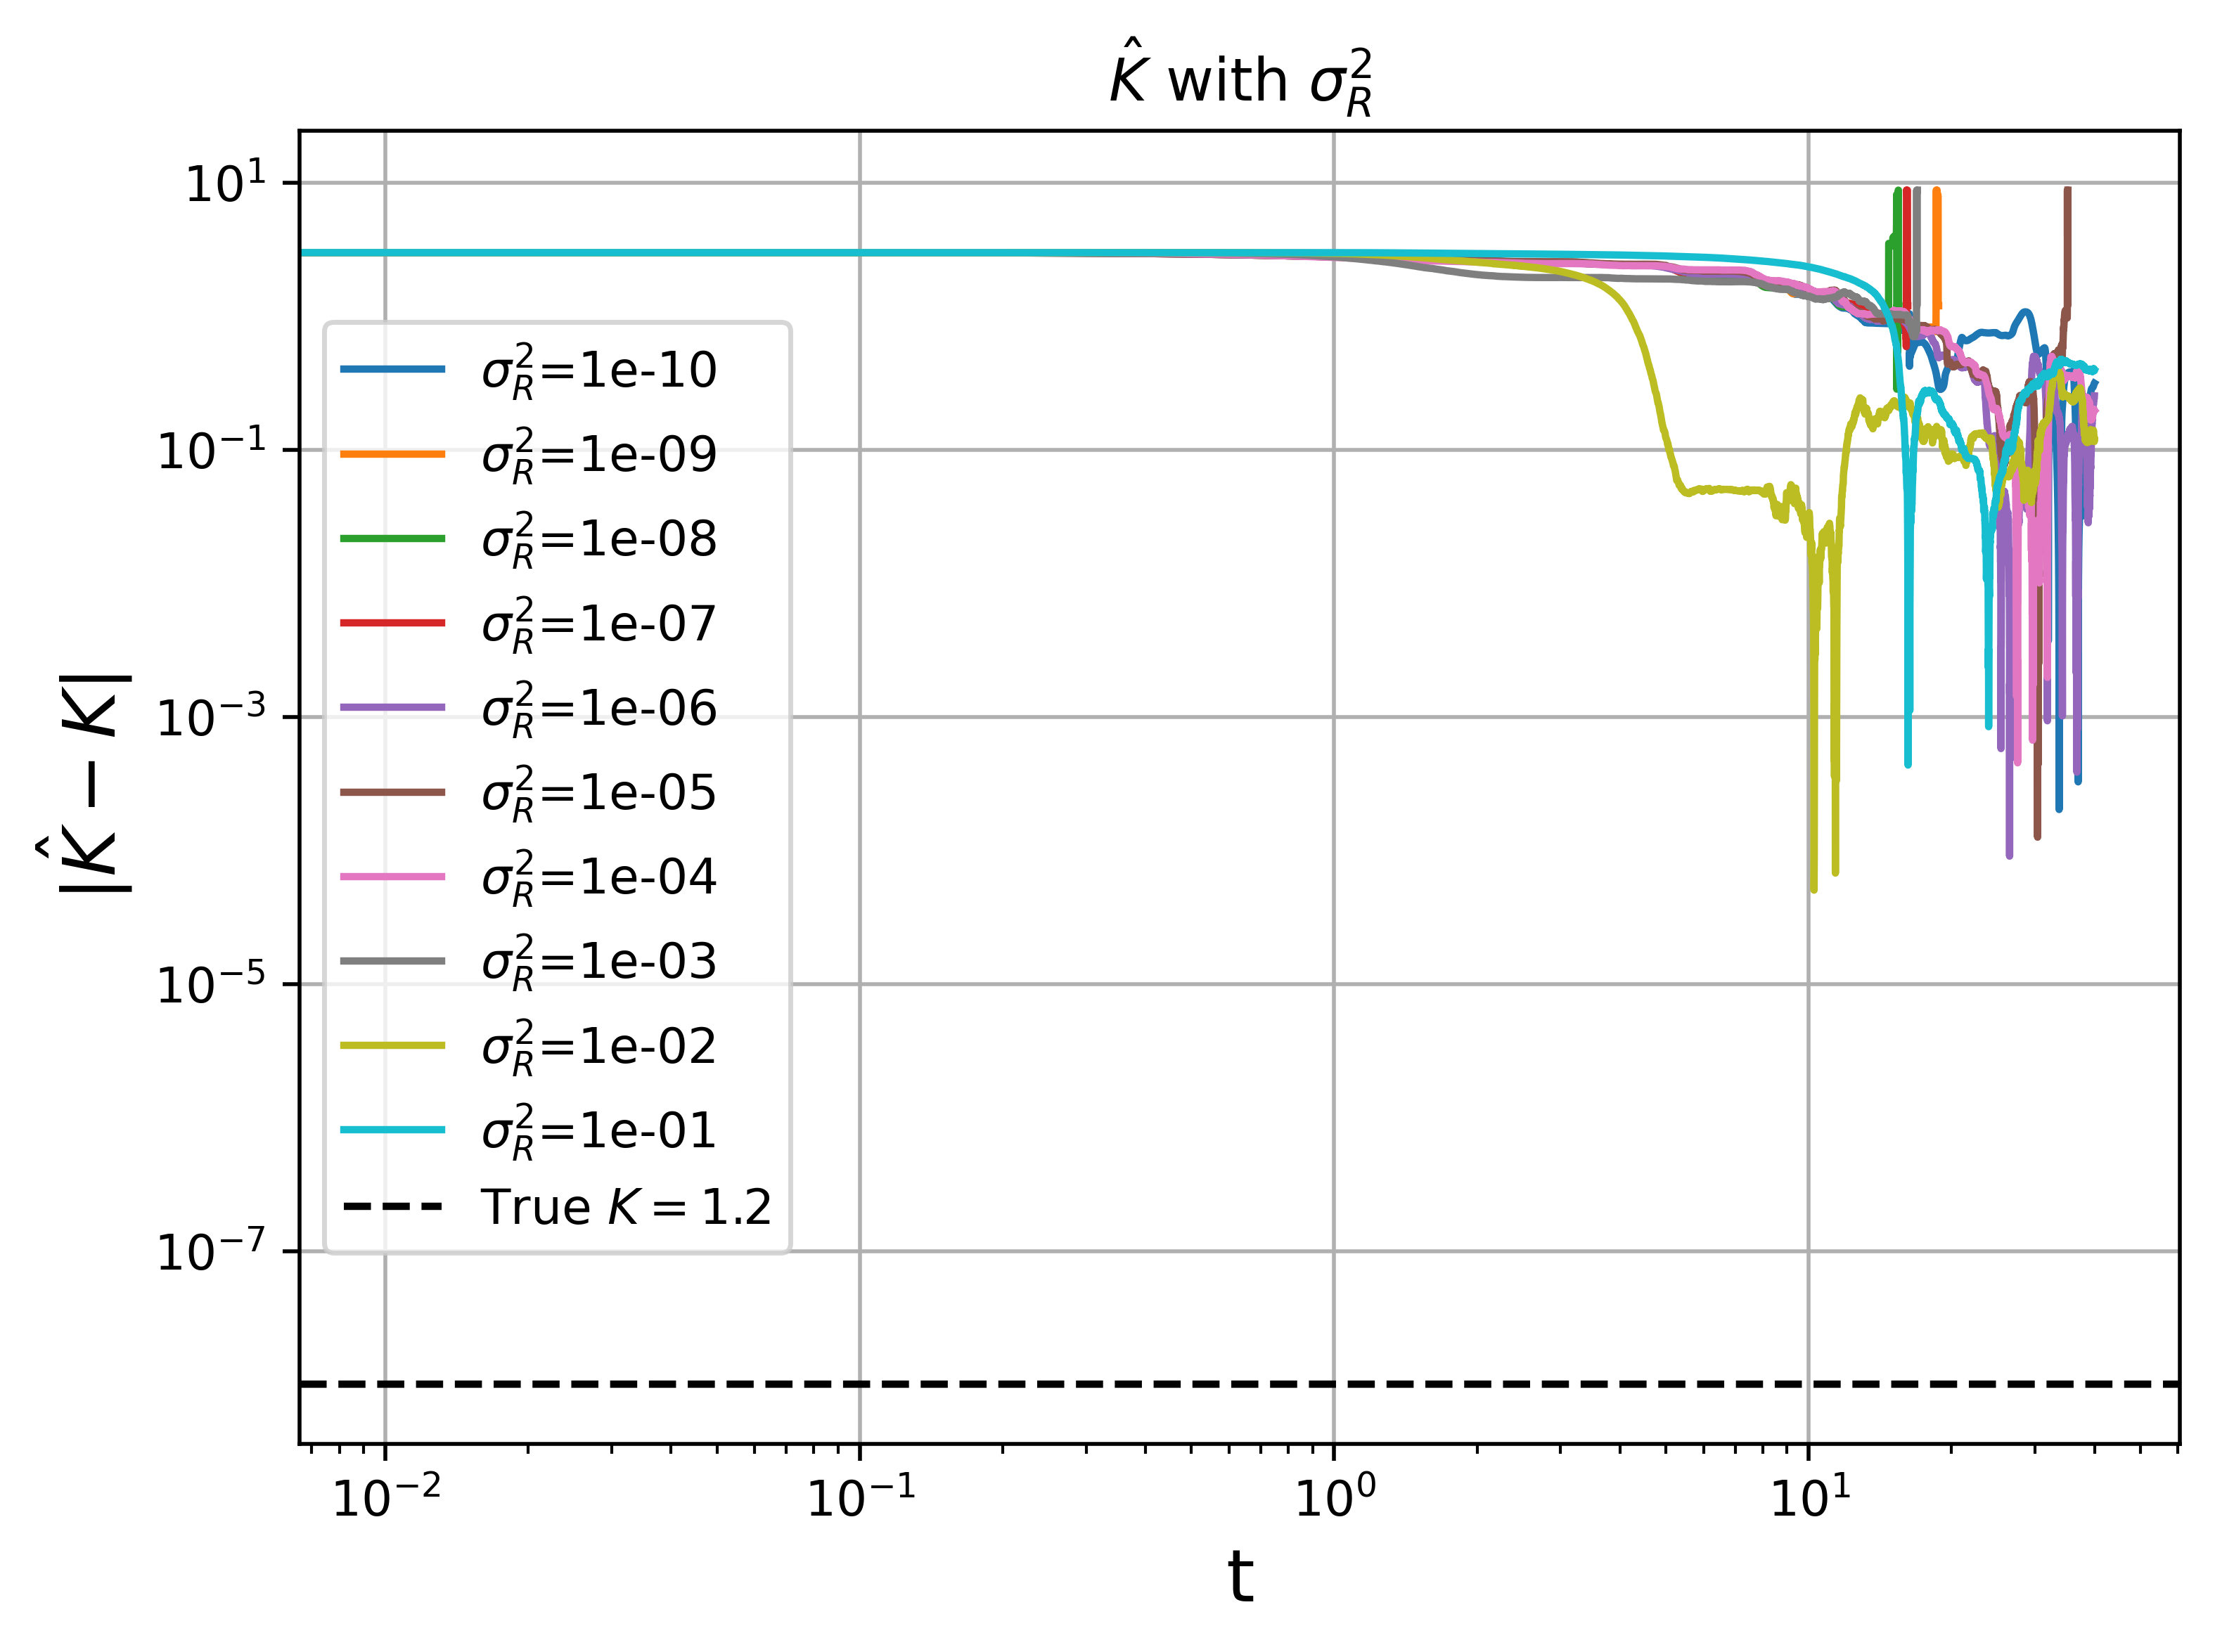

In [108]:
# 여러 R_meas 값에 대해 EKF를 돌리고, K 추정치의 추이를 그래프로 비교
plt.figure(dpi=500)
R_meas_list = [1e-10,1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1]
K_est_dict = {}
for Rm in R_meas_list:
    x_hats_tmp, _, _, _ ,_ = run_ekf_rank1_orig(
        theta_random, 
        K_init=K + 1.0,
        omega=omega,
        t=t,
        rs=rs,
        R_meas=Rm,
        jitterP=1e-5,     # P_bar 정칙화 (네 코드와 동일)
        s_floor=1e-6,     # S 하한 (네 코드와 동일)
        P_floor=1e-12,    # P_hat 요소 바닥 (네 코드와 동일)
        delta_K_init=2.0, # 초기 K 오프셋: K_init + 2
        add_meas_noise=True)
    K_est_dict[Rm] = x_hats_tmp[:, -1]

for Rm in R_meas_list:
    plt.plot(t, np.abs(K_est_dict[Rm]-K), label=fr'$\sigma_R^2$={Rm:.0e}')
plt.axhline(1e-8, color='black', ls='--', label=rf'True $K = {K}$')
plt.xlabel('t', fontsize=15)
plt.ylabel(r'$|\hat{K} - K|$', fontsize=15)
plt.title(r'$\hat{K}$ with $\sigma_{R}^2$')
plt.legend()
plt.loglog()
plt.grid()
plt.tight_layout()
plt.show()



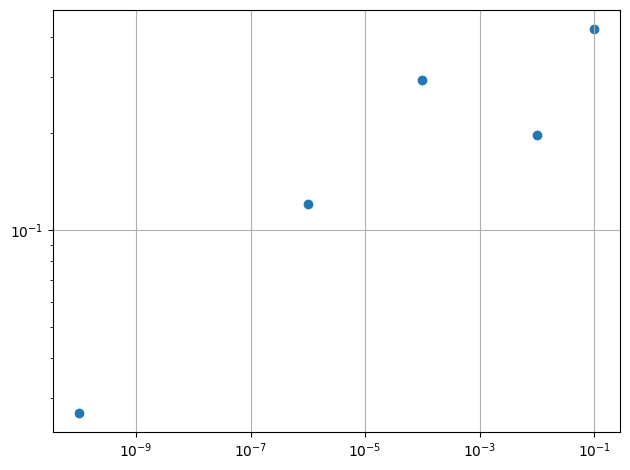

In [109]:
K_est_orig = np.array([K_est_dict[Rm][-500:] for Rm in R_meas_list])
K_est_orig_mean = np.mean(K_est_orig,axis=1)
plt.scatter(R_meas_list,np.abs(K_est_orig_mean-K))
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.show()

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/807902518.py:185: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H @ v + R_meas)      # scalar
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_50582/807902518.py:200: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sK = float(H @ F_Kcol.reshape(-1,1))


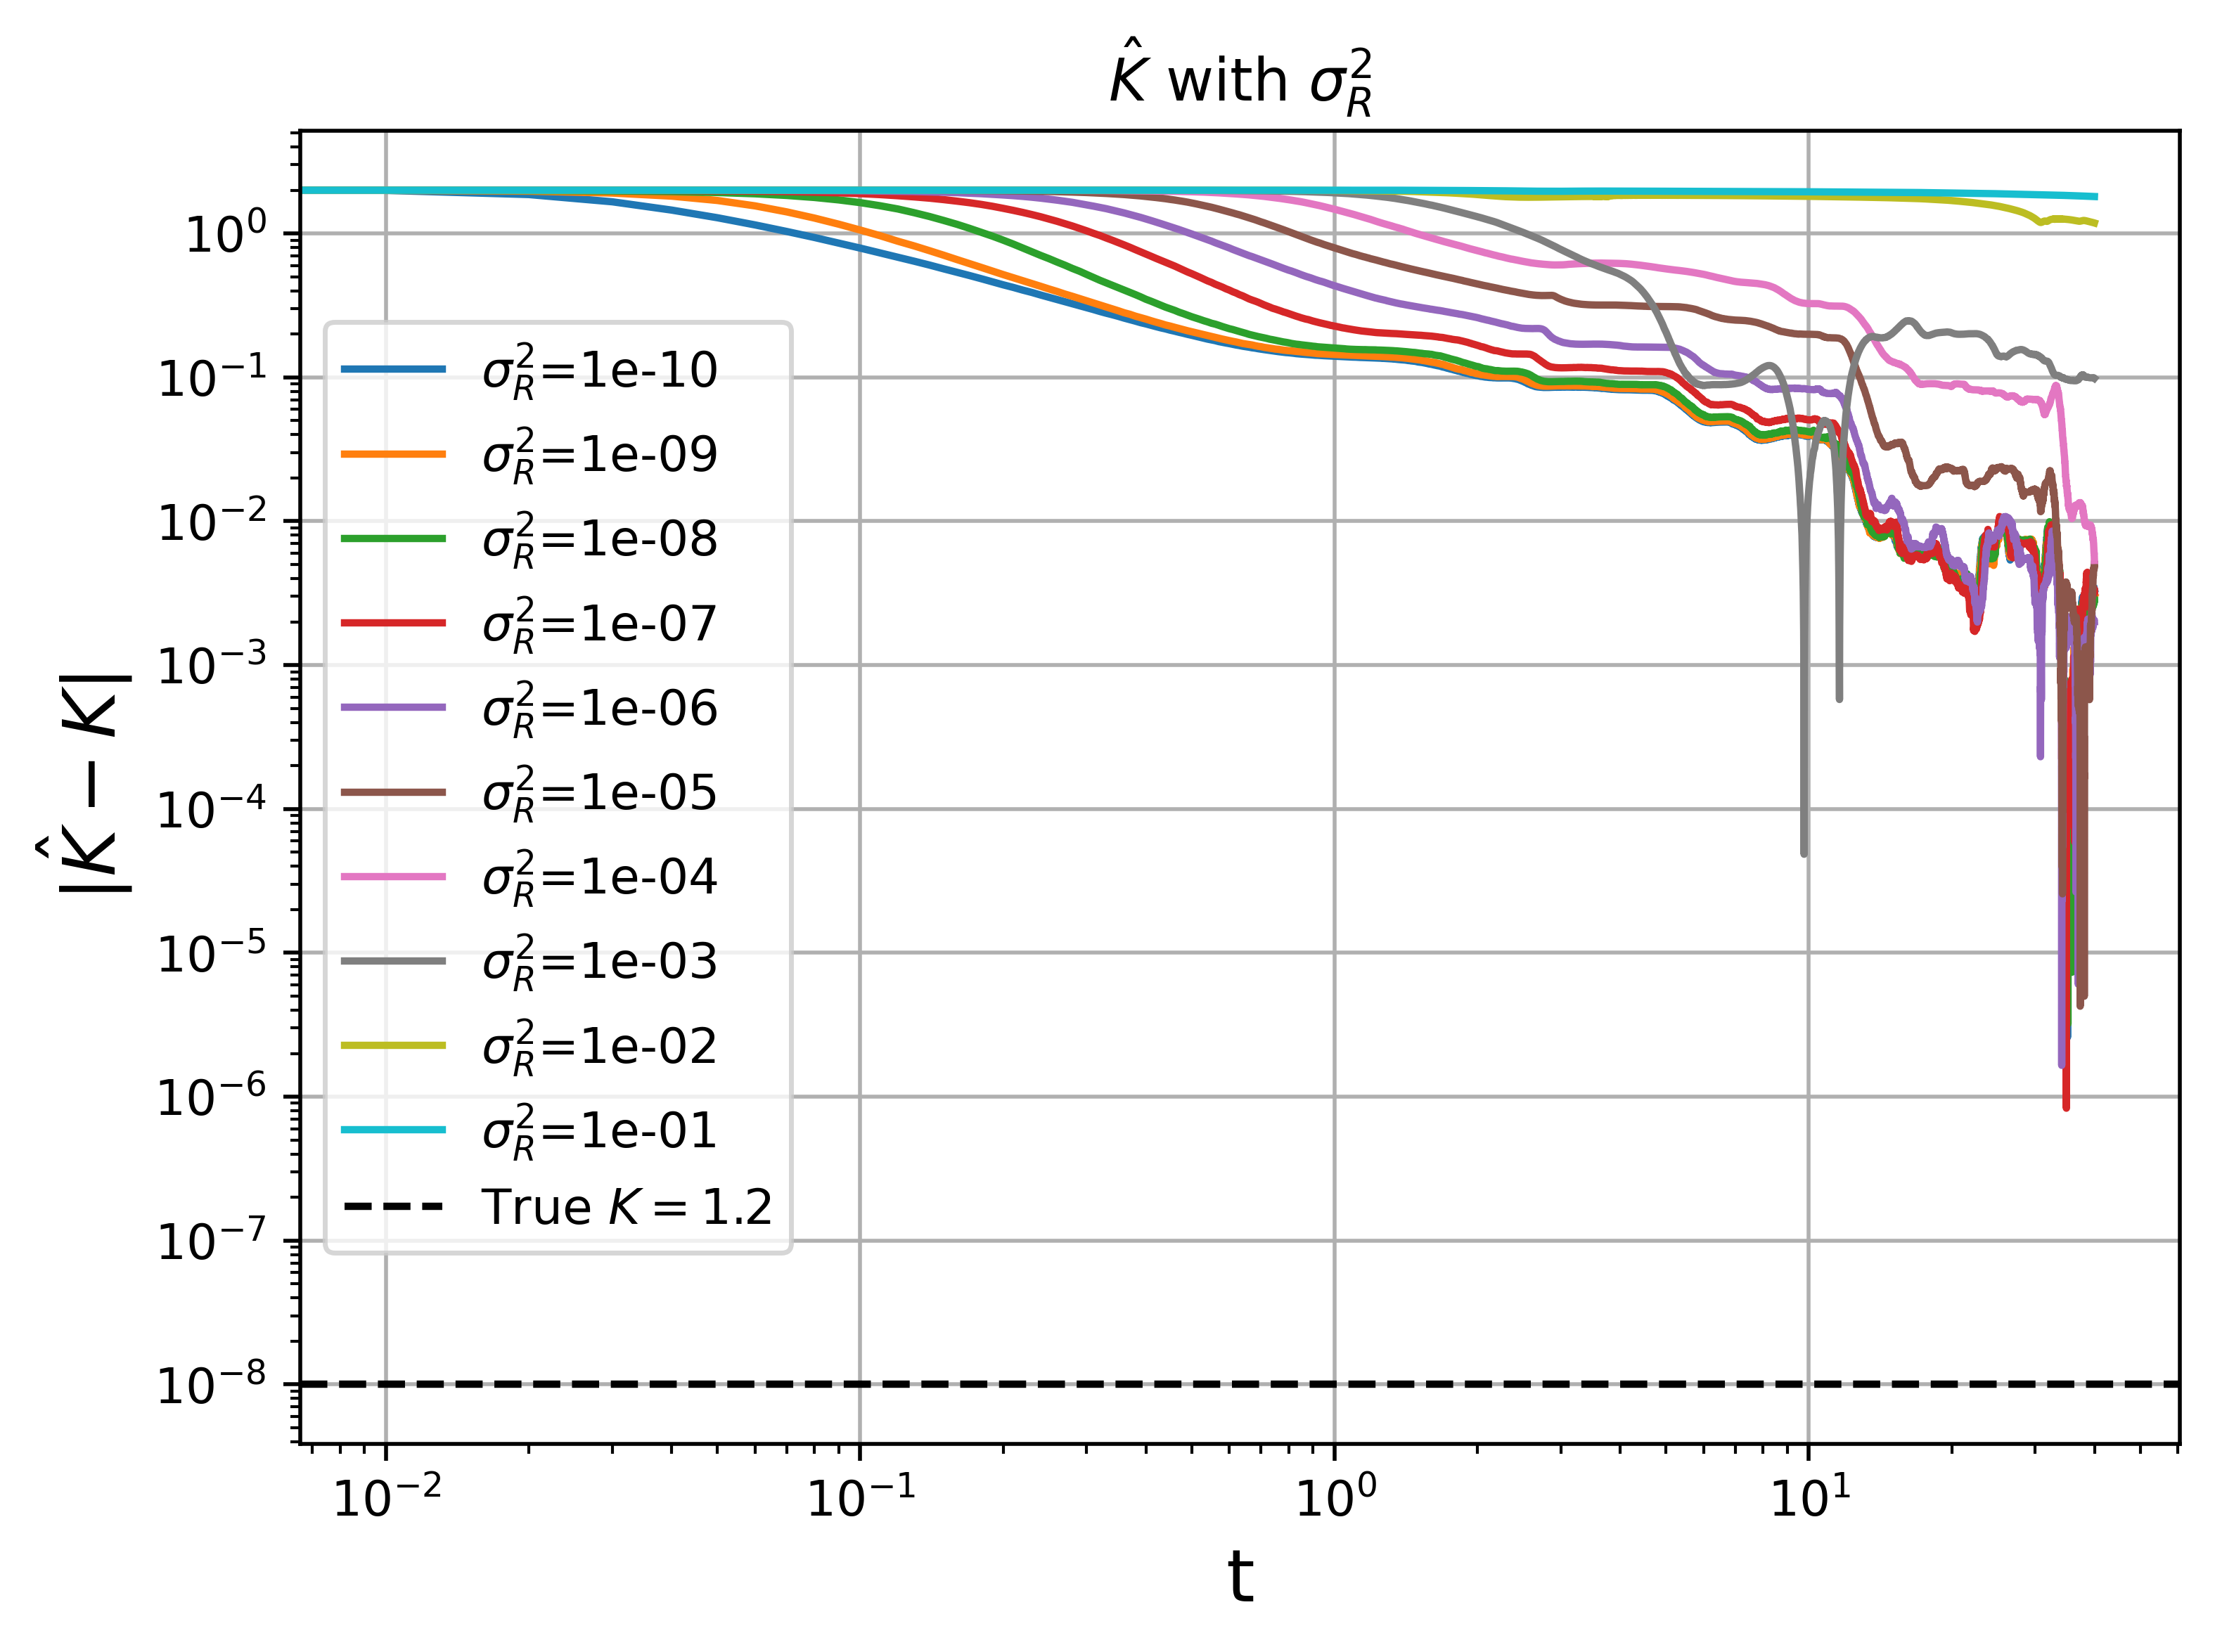

In [110]:
# 여러 R_meas 값에 대해 EKF를 돌리고, K 추정치의 추이를 그래프로 비교
plt.figure(dpi=500)
R_meas_list = [1e-10,1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1]
K_est_dict = {}
for Rm in R_meas_list:
    x_hats_tmp, _, _, _ = run_ekf_rank1_fast(
        theta_random=theta_random,
        K_init=K + 2.0,
        omega=omega,
        t=t,
        rs=rs,
        R_meas=Rm,
        Q_K=1e-8,
        epsP=1e-12, epsS=1e-10, jitterP=1e-8,
        sigmaK_tol=1e-7, NIS_low=0.3, NIS_high=3.0,
        sens_tol=1e-7, W=50, eig_every=100
    )
    K_est_dict[Rm] = x_hats_tmp[:, -1]

for Rm in R_meas_list:
    plt.plot(t, np.abs(K_est_dict[Rm]-K), label=fr'$\sigma_R^2$={Rm:.0e}')
plt.axhline(1e-8, color='black', ls='--', label=rf'True $K = {K}$')
plt.xlabel('t', fontsize=15)
plt.ylabel(r'$|\hat{K} - K|$', fontsize=15)
plt.title(r'$\hat{K}$ with $\sigma_{R}^2$')
plt.legend()
plt.loglog()
plt.grid()
plt.tight_layout()
plt.show()


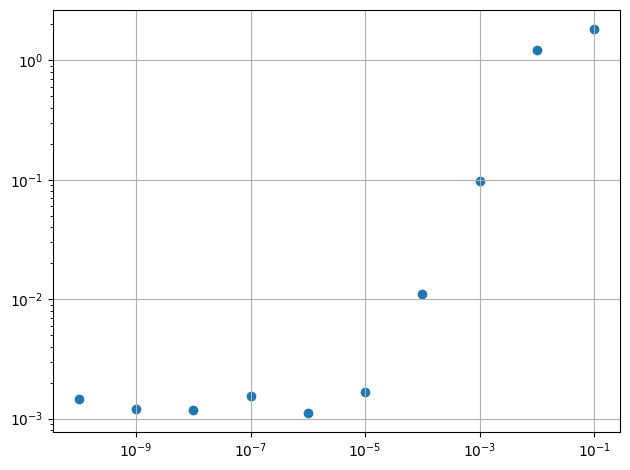

In [112]:

K_ests = np.array([K_est_dict[Rm][-500:] for Rm in R_meas_list])
K_ests_mean = np.mean(K_ests,axis=1)
plt.scatter(R_meas_list,np.abs(K_ests_mean-K))
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.show()

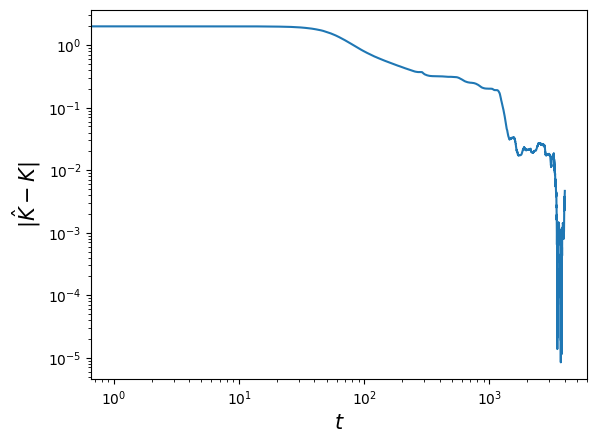

In [113]:
plt.plot(np.abs(K_est - K))
plt.ylabel(r'$|\hat{K} - K|$',fontsize=15)
plt.xlabel(r'$t$',fontsize=15)
# plt.ylim(1e-20,2)
plt.loglog()
plt.show()

# EnKf

In [149]:
import numpy as np
from numba import njit, prange

# ---------------------------
# Angle helpers (JIT)
# ---------------------------
@njit(fastmath=True)
def wrap_angle(a):
    # (-pi, pi]로 래핑
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v / (2.0*np.pi))
    return v - np.pi

@njit(fastmath=True)
def wrap_angle_vec(v):
    out = np.empty_like(v)
    for i in range(v.size):
        out[i] = wrap_angle(v[i])
    return out

@njit(fastmath=True)
def order_params(T):
    # X=mean(cos), Y=mean(sin)
    csum = 0.0
    ssum = 0.0
    N = T.size
    for i in range(N):
        csum += np.cos(T[i])
        ssum += np.sin(T[i])
    invN = 1.0/N
    return csum*invN, ssum*invN

@njit(fastmath=True)
def h_measure(T):
    X, Y = order_params(T)
    return np.sqrt(X*X + Y*Y)   # R in [0,1]

# ---------------------------
# Forecast step (O(N), JIT)
# ---------------------------
@njit(fastmath=True)
def forecast_one(theta, K, omega, dt):
    # dθ_i = ω_i + K * (Y cosθ_i - X sinθ_i)
    X, Y = order_params(theta)
    N = theta.size
    theta_new = np.empty_like(theta)
    for i in range(N):
        th = theta[i]
        dtheta = omega[i] + K*(Y*np.cos(th) - X*np.sin(th))
        theta_new[i] = wrap_angle(th + dt*dtheta)
    return theta_new, K  # K는 random-walk: 잡음은 따로 더함

@njit(fastmath=True, parallel=True)
def forecast_ensemble(Ens, omega, dt, q_theta_std, q_K_std):
    # Ens: shape (N+1, M)  [0..N-1: theta dims, N: K]
    Np1, M = Ens.shape
    N = Np1 - 1
    for m in prange(M):
        theta = Ens[:N, m]
        K     = Ens[N,  m]
        theta_f, K_f = forecast_one(theta, K, omega, dt)
        # 과정잡음 추가
        if q_theta_std > 0.0:
            for i in range(N):
                theta_f[i] = wrap_angle(theta_f[i] + q_theta_std*np.random.randn())
        if q_K_std > 0.0:
            K_f = K_f + q_K_std*np.random.randn()
        Ens[:N, m] = theta_f
        Ens[N,  m] = K_f

# ---------------------------
# Ensemble mean / anomalies (JIT)
# ---------------------------
@njit(fastmath=True)
def circular_mean_by_dim(E_theta):  # E_theta: (N, M)
    N, M = E_theta.shape
    mean_theta = np.empty(N)
    for i in range(N):
        C = 0.0; S = 0.0
        for m in range(M):
            th = E_theta[i, m]
            C += np.cos(th); S += np.sin(th)
        mean_theta[i] = np.arctan2(S, C)
    return mean_theta

@njit(fastmath=True, parallel=True)
def anomalies(E_theta, mean_theta, E_K, mean_K):
    # 반환: A_theta (N,M), A_K (M,)
    N, M = E_theta.shape
    A_theta = np.empty((N, M))
    A_K     = np.empty(M)
    for m in prange(M):
        for i in range(N):
            A_theta[i, m] = wrap_angle(E_theta[i, m] - mean_theta[i])  # 각도 잔차
        A_K[m] = E_K[m] - mean_K
    return A_theta, A_K

@njit(fastmath=True)
def diag_var_from_ensemble(E_theta, mean_theta, E_K, mean_K):
    # 진단용: 각 차원의 분산(표본) 추정 (diag of sample cov)
    N, M = E_theta.shape
    var_diag = np.empty(N+1)
    inv = 1.0 / (M-1) if M > 1 else 0.0
    for i in range(N):
        acc = 0.0
        for m in range(M):
            d = wrap_angle(E_theta[i, m] - mean_theta[i])
            acc += d*d
        var_diag[i] = acc * inv
    # K
    acc = 0.0
    for m in range(M):
        d = E_K[m] - mean_K
        acc += d*d
    var_diag[N] = acc * inv
    return var_diag

# ---------------------------
# Analysis step (stochastic EnKF, scalar obs) (JIT)
# ---------------------------
@njit(fastmath=True)
def analysis_scalar(Ens, z_meas, R_var, inflation):
    # Ens: (N+1, M)
    Np1, M = Ens.shape
    N = Np1 - 1
    # (1) 예측 평균
    mean_theta = circular_mean_by_dim(Ens[:N, :])
    mean_K = 0.0
    for m in range(M):
        mean_K += Ens[N, m]
    mean_K /= M

    # (2) 예측 잔차(불확실도) + 인플레이션
    A_theta, A_K = anomalies(Ens[:N, :], mean_theta, Ens[N, :], mean_K)
    if inflation != 1.0:
        for m in range(M):
            for i in range(N):
                A_theta[i, m] *= inflation
            A_K[m] *= inflation

    # (3) 관측 예측
    y = np.empty(M)
    for m in range(M):
        y[m] = h_measure(Ens[:N, m])
    # 예측 관측 평균
    y_bar = 0.0
    for m in range(M):
        y_bar += y[m]
    y_bar /= M
    # 관측 잔차
    y_anom = y - y_bar

    # (4) 공분산 및 칼만 이득
    inv = 1.0 / (M - 1) if M > 1 else 0.0

    # P_yy
    s_yy = 0.0
    for m in range(M):
        s_yy += y_anom[m]*y_anom[m]
    P_yy = s_yy * inv + R_var
    if P_yy < 1e-12:
        P_yy = 1e-12

    # P_xy (n x 1)
    K_gain = np.empty(N+1)
    # theta 부분
    for i in range(N):
        acc = 0.0
        for m in range(M):
            acc += A_theta[i, m] * y_anom[m]
        K_gain[i] = (acc * inv) / P_yy
    # K 성분
    acc = 0.0
    for m in range(M):
        acc += A_K[m] * y_anom[m]
    K_gain[N] = (acc * inv) / P_yy

    # (5) 퍼터브드 관측으로 개별 업데이트
    stdR = np.sqrt(R_var)
    for m in range(M):
        y_tilde = z_meas + stdR*np.random.randn()
        innov = y_tilde - y[m]
        # 상태 업데이트
        for i in range(N):
            Ens[i, m] = wrap_angle(Ens[i, m] + K_gain[i]*innov)
        Ens[N, m] = Ens[N, m] + K_gain[N]*innov

    return y_bar, mean_theta, mean_K

# ---------------------------
# Top-level EnKF runner
# ---------------------------
def enkf_thetas_numba(
    rs, t, theta0, K0, omega, *,
    M=128,               # 앙상블 크기
    R_meas=1e-8,         # 관측 잡음 분산
    Q_theta=0.0,         # 위상 과정잡음 표준편차가 아니라 '분산'을 넣고 싶다면 아래서 sqrt
    Q_K=1e-8,
    init_theta_std=1e-2,
    init_K_std=1e-2,
    inflation=1.02,      # 1.0이면 사용 안 함
    seed=0
):
    rs = np.asarray(rs, dtype=np.float64)
    t  = np.asarray(t,  dtype=np.float64)
    theta0 = np.asarray(theta0, dtype=np.float64)
    omega  = np.asarray(omega,  dtype=np.float64)

    N = theta0.size
    dt = float(t[1]-t[0]) if len(t) > 1 else 1.0
    rng = np.random.default_rng(seed)

    # 초기 앙상블 (작은 랜덤 퍼터베이션)
    Ens = np.empty((N+1, M), dtype=np.float64)
    for m in range(M):
        Ens[:N, m] = wrap_angle_vec(theta0 + init_theta_std * rng.standard_normal(N))
        Ens[N,  m] = float(K0 + init_K_std * rng.standard_normal())

    # 로그 저장
    Tn = len(t)
    x_means = np.zeros((Tn, N+1))
    P_diag  = np.zeros((Tn, N+1))
    z_hats  = np.zeros(Tn)

    # 첫 시각 기록
    mean_theta0 = circular_mean_by_dim(Ens[:N, :])
    mean_K0     = float(np.mean(Ens[N, :]))
    x_means[0, :N] = mean_theta0
    x_means[0,  N] = mean_K0
    P_diag[0]      = diag_var_from_ensemble(Ens[:N, :], mean_theta0, Ens[N, :], mean_K0)
    z_hats[0]      = h_measure(mean_theta0)

    q_theta_std = np.sqrt(Q_theta) if Q_theta > 0 else 0.0
    q_K_std     = np.sqrt(Q_K)     if Q_K     > 0 else 0.0

    for k in range(1, Tn):
        z_meas = float(rs[k])  # 필요시 np.clip(z_meas,1e-9,1.0) 가능

        # ---- Forecast ----
        forecast_ensemble(Ens, omega, dt, q_theta_std, q_K_std)

        # ---- Analysis ----
        z_bar, mean_theta, mean_K = analysis_scalar(Ens, z_meas, R_meas, inflation)

        # 로그
        x_means[k, :N] = mean_theta
        x_means[k,  N] = mean_K
        P_diag[k]      = diag_var_from_ensemble(Ens[:N, :], mean_theta, Ens[N, :], mean_K)
        z_hats[k]      = z_bar

    return x_means, P_diag, z_hats, Ens


In [166]:
seed = None
N = 10000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.01
t = np.arange(0,40,dt)
K = 1.9
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [167]:
# 주어진 것: rs (측정된 R_t), t (시간축), theta_random (초기 위상 N개), omega (자연주파수), K 초기값
x_means, P_diag, z_hats, Ens_final = enkf_thetas_numba(
    rs=rs, t=t,
    theta0=theta_random,
    K0=K +1,
    omega=omega,
    M=128,            # 64~256 권장
    R_meas=1e-8,
    Q_theta=0.0,      # 결정적 모델이면 0 또는 아주 작게
    Q_K=1e-8,
    init_theta_std=1e-2,
    init_K_std=1e-2,
    inflation=1.02,   # 필수는 아니지만 수렴 속도/안정화에 도움
    seed=42
)

K_est = x_means[:, -1]   # 시간에 따른 K 추정치
R_pred = z_hats          # 예측된 R(t)


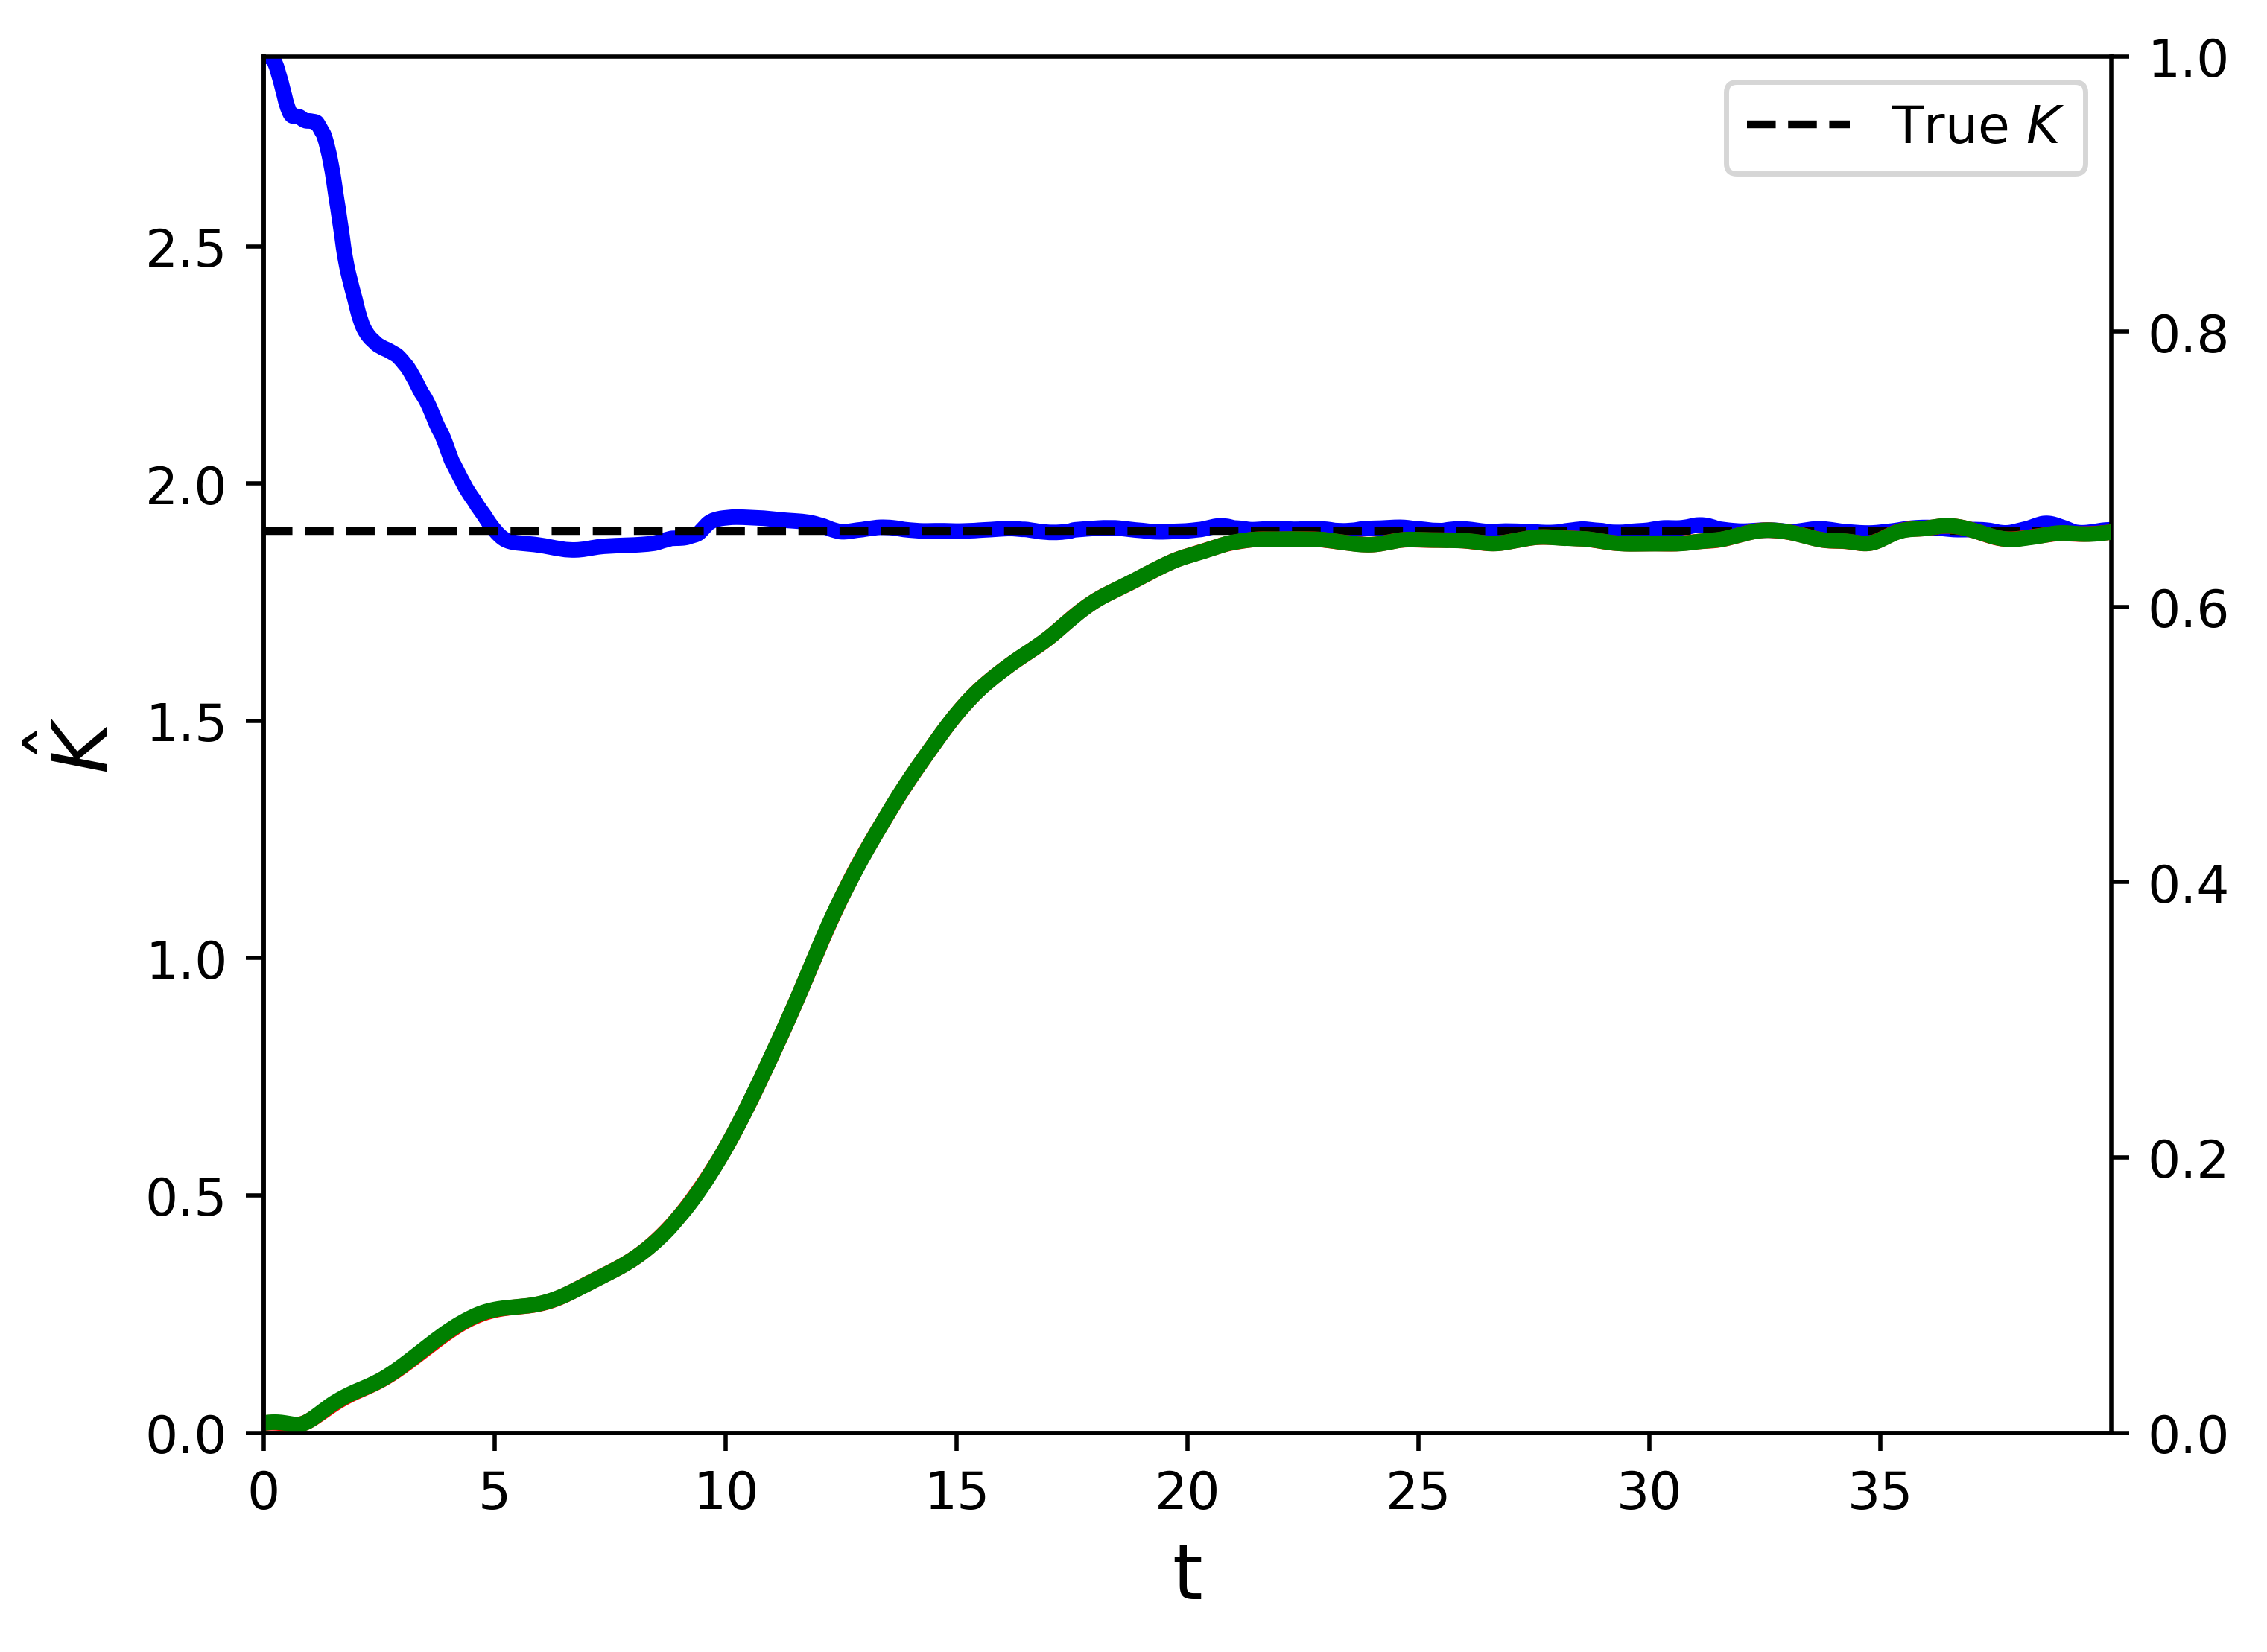

In [171]:
plt.figure(dpi=500)
# plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est,color='blue',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,R_pred,color='green',lw=3)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Text(0.5, 0, '$t$')

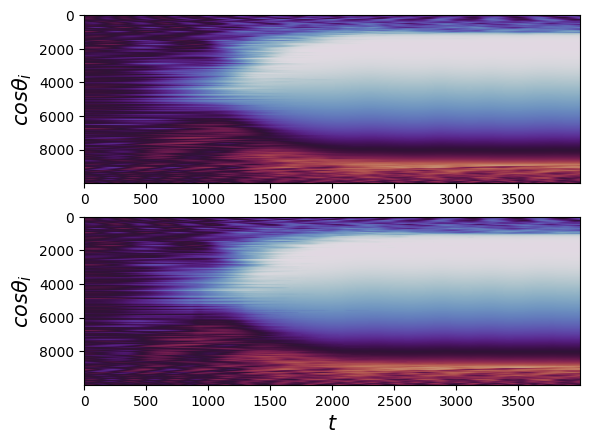

In [172]:
theta = (theta+np.pi)%(2*np.pi) - np.pi
plt.subplot(211)
plt.imshow(np.cos(theta).T,cmap='twilight')
plt.gca().set_aspect('auto')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.subplot(212)
plt.imshow(np.cos(x_means[:,:N]).T,cmap='twilight')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.gca().set_aspect('auto')
plt.xlabel(r'$t$',fontsize=15)


Text(0, 0.5, '$\\theta_i-\\hat{\\theta}_i$')

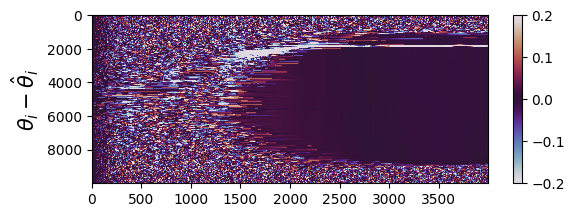

In [173]:
plt.subplot(211)
plt.imshow(theta.T - x_means[:,:N].T,cmap='twilight',vmin=-0.2,vmax=0.2)
plt.gca().set_aspect('auto')
plt.colorbar()
plt.ylabel(r'$\theta_i-\hat{\theta}_i$',fontsize=15)



# Sigma point

In [138]:
import numpy as np
from numba import njit, prange

# ---------------------------
# Angle helpers (JIT)
# ---------------------------
@njit(fastmath=True)
def wrap_angle_scalar(a):
    # wrap to (-pi, pi]
    v = a + np.pi
    v = v - 2.0*np.pi * np.floor(v / (2.0*np.pi))
    return v - np.pi

@njit(fastmath=True, parallel=True)
def wrap_angle_matrix_rows(A, N):
    L = A.shape[0]
    for r in prange(L):
        for i in range(N):
            A[r, i] = wrap_angle_scalar(A[r, i])

@njit(fastmath=True)
def order_params(T):
    csum = 0.0
    ssum = 0.0
    N = T.size
    for i in range(N):
        csum += np.cos(T[i])
        ssum += np.sin(T[i])
    invN = 1.0 / N
    return csum*invN, ssum*invN

# ---------------------------
# Models (JIT)
# ---------------------------
@njit(fastmath=True)
def f_propagate_row(x_row, omega, dt, out_row):
    """
    x_row: (N+1,) sigma point [theta..., K]
    out_row: (N+1,) result
    """
    N = omega.size
    K = x_row[N]
    # order params of this sigma point
    X, Y = order_params(x_row[:N])

    for i in range(N):
        th = x_row[i]
        c = np.cos(th)
        s = np.sin(th)
        dtheta = omega[i] + K * (Y*c - X*s)
        out_row[i] = wrap_angle_scalar(th + dt * dtheta)
    out_row[N] = K

@njit(fastmath=True, parallel=True)
def propagate_sigma_points(Xsig, omega, dt):
    L, n = Xsig.shape
    N = omega.size
    Xprop = np.empty_like(Xsig)
    for a in prange(L):
        f_propagate_row(Xsig[a], omega, dt, Xprop[a])
    return Xprop

@njit(fastmath=True)
def h_measure_row(T):
    X, Y = order_params(T)
    return np.sqrt(X*X + Y*Y)

@njit(fastmath=True, parallel=True)
def measure_sigma_points(Xprop, N):
    L = Xprop.shape[0]
    Zsig = np.empty(L)
    for a in prange(L):
        Zsig[a] = h_measure_row(Xprop[a, :N])
    return Zsig

# ---------------------------
# Unscented weights & sigma points (JIT)
# ---------------------------
@njit(fastmath=True)
def unscented_weights(n, alpha, beta, kappa):
    lam = alpha*alpha * (n + kappa) - n
    c = n + lam
    L = 2*n + 1
    Wm = np.empty(L)
    Wc = np.empty(L)
    half = 0.5 / c
    for i in range(L):
        Wm[i] = half
        Wc[i] = half
    Wm[0] = lam / c
    Wc[0] = Wm[0] + (1.0 - alpha*alpha + beta)
    return lam, c, Wm, Wc

@njit(fastmath=True)
def sigma_points_diag(mean, P_diag, lam, c):
    n = mean.size
    L = 2*n + 1
    Xsig = np.empty((L, n))
    # center
    for j in range(n):
        Xsig[0, j] = mean[j]
    # spreads
    for i in range(n):
        s = np.sqrt(c * max(P_diag[i], 1e-18))
        # plus
        for j in range(n):
            Xsig[1+i, j] = mean[j]
        Xsig[1+i, i] = mean[i] + s
        # minus
        for j in range(n):
            Xsig[1+n+i, j] = mean[j]
        Xsig[1+n+i, i] = mean[i] - s
    return Xsig

# ---------------------------
# Circular mean & residuals (JIT)
# ---------------------------
@njit(fastmath=True, parallel=True)
def circular_mean_by_dim(Theta_sigma, Wm):
    L, N = Theta_sigma.shape
    out = np.empty(N)
    for j in prange(N):
        C = 0.0
        S = 0.0
        for a in range(L):
            th = Theta_sigma[a, j]
            C += Wm[a] * np.cos(th)
            S += Wm[a] * np.sin(th)
        out[j] = np.arctan2(S, C)
    return out

@njit(fastmath=True, parallel=True)
def residuals_dX(Theta_sigma, theta_mean, K_sigma, K_mean):
    L, N = Theta_sigma.shape
    n = N + 1
    dX = np.empty((L, n))
    for a in prange(L):
        for j in range(N):
            dX[a, j] = wrap_angle_scalar(Theta_sigma[a, j] - theta_mean[j])
        dX[a, N] = K_sigma[a] - K_mean
    return dX

# ---------------------------
# Covariances (JIT)
# ---------------------------
@njit(fastmath=True)
def cov_pred_diag(dX, Wc, Q_diag):
    L, n = dX.shape
    P = np.empty(n)
    for m in range(n):
        acc = 0.0
        for a in range(L):
            v = dX[a, m]
            acc += Wc[a] * v * v
        P[m] = acc + Q_diag[m]
        if P[m] < 1e-18:
            P[m] = 1e-18
    return P

@njit(fastmath=True)
def cross_cov_and_gain_diag(dX, dz, Wc, Pzz, P_bar_diag):
    L, n = dX.shape
    Pxz = np.empty(n)
    invPzz = 1.0 / max(Pzz, 1e-18)
    for m in range(n):
        acc = 0.0
        for a in range(L):
            acc += Wc[a] * dX[a, m] * dz[a]
        Pxz[m] = acc
    # K = Pxz / Pzz
    for m in range(n):
        Pxz[m] = Pxz[m] * invPzz
    # P_hat = P_bar - K * Pzz * K  (diag)
    P_hat = np.empty(n)
    for m in range(n):
        km = Pxz[m]
        P_hat[m] = max(P_bar_diag[m] - km * Pzz * km, 1e-18)
    return Pxz, P_hat

# ---------------------------
# UKF (diag) — Python wrapper + JIT inner kernels
# ---------------------------
def ukf_thetas_numba_diag(
    rs, t, theta0, K0, omega,
    Q_theta=0.0, Q_K=1e-8, R_meas=1e-8,
    alpha=None, beta=2.0, kappa=0.0,
    dtype=np.float64
):
    rs = np.asarray(rs, dtype=dtype)
    t  = np.asarray(t,  dtype=dtype)
    theta0 = np.asarray(theta0, dtype=dtype)
    omega  = np.asarray(omega, dtype=dtype)

    N = theta0.size
    n = N + 1
    dt = float(t[1] - t[0]) if len(t) > 1 else 1.0

    if alpha is None:
        # 차원이 크면 alpha를 키워야 수치 안정/포인트 확산 확보
        alpha = max(1e-3, 1.0/np.sqrt(n))

    lam, c, Wm, Wc = unscented_weights(n, alpha, beta, kappa)

    # init
    x = np.empty(n, dtype=dtype)
    for i in range(N):
        x[i] = wrap_angle_scalar(theta0[i])
    x[N] = dtype(K0)

    P_diag = np.full(n, dtype(1e-6))
    Q_diag = np.full(n, dtype(Q_theta))
    Q_diag[-1] = dtype(Q_K)
    R = dtype(R_meas)

    Tn = len(t)
    x_hats = np.empty((Tn, n), dtype=dtype)
    P_hats = np.empty((Tn, n), dtype=dtype)
    z_hats = np.empty(Tn, dtype=dtype)

    x_hats[0] = x
    P_hats[0] = P_diag
    # 첫 z_hat
    z_hats[0] = h_measure_row(x[:N])

    for k in range(1, Tn):
        z_meas = float(np.clip(rs[k], 1e-9, 1.0))

        # --- sigma points ---
        Xsig = sigma_points_diag(x, P_diag, lam, c)
        # angles wrap
        wrap_angle_matrix_rows(Xsig, N)

        # --- propagate ---
        Xprop = propagate_sigma_points(Xsig, omega, dt)

        Theta_sigma = Xprop[:, :N]
        K_sigma     = Xprop[:,  N]

        # predicted mean
        theta_mean = circular_mean_by_dim(Theta_sigma, Wm)
        K_mean = float(np.sum(Wm * K_sigma))

        x_bar = np.empty(n, dtype=dtype)
        x_bar[:N] = theta_mean
        x_bar[N]  = K_mean

        # residuals
        dX = residuals_dX(Theta_sigma, theta_mean, K_sigma, K_mean)

        # P_bar (diag)
        P_bar = cov_pred_diag(dX, Wc, Q_diag)

        # --- measurement ---
        Zsig = measure_sigma_points(Xprop, N)
        z_bar = float(np.sum(Wm * Zsig))

        dz = Zsig - z_bar
        # Pzz
        acc = 0.0
        for a in range(Zsig.size):
            acc += Wc[a] * dz[a] * dz[a]
        Pzz = float(acc + R)
        if Pzz < 1e-12:
            Pzz = 1e-12

        # cross-cov & gain (diag)
        K_gain, P_hat = cross_cov_and_gain_diag(dX, dz, Wc, Pzz, P_bar)

        # update
        innov = z_meas - z_bar
        x = x_bar + K_gain * innov
        # wrap angles
        for i in range(N):
            x[i] = wrap_angle_scalar(x[i])
        # optional: clamp K
        if x[N] < 1e-6: x[N] = 1e-6
        if x[N] > 1e2:  x[N] = 1e2

        P_diag = P_hat

        x_hats[k] = x
        P_hats[k] = P_diag
        z_hats[k] = z_bar

    return x_hats, P_hats, z_hats


In [139]:
# 예시: 네가 이미 갖고 있는 것들
# rs, t, theta_random, omega, K
x_hats, P_hats, z_hats = ukf_thetas_numba_diag(
    rs=rs, t=t,
    theta0=theta_random,
    K0=K + 1.0,
    omega=omega,
    Q_theta=0.0,     # 결정적 위상 모델이면 0 또는 아주 작게
    Q_K=1e-8,        # K는 천천히 변한다고 가정
    R_meas=1e-8,
    alpha=None, beta=2.0, kappa=0.,
    dtype=np.float64 # 더 빠르게 하고 싶으면 np.float32
)
K_est = x_hats[:, -1]
R_pred = z_hats


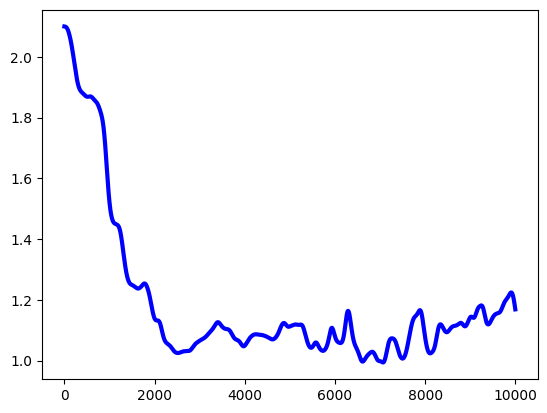

In [148]:
plt.plot(K_est,color='blue',lw=3)

ValueError: x and y must have same first dimension, but have shapes (4000,) and (10000,)

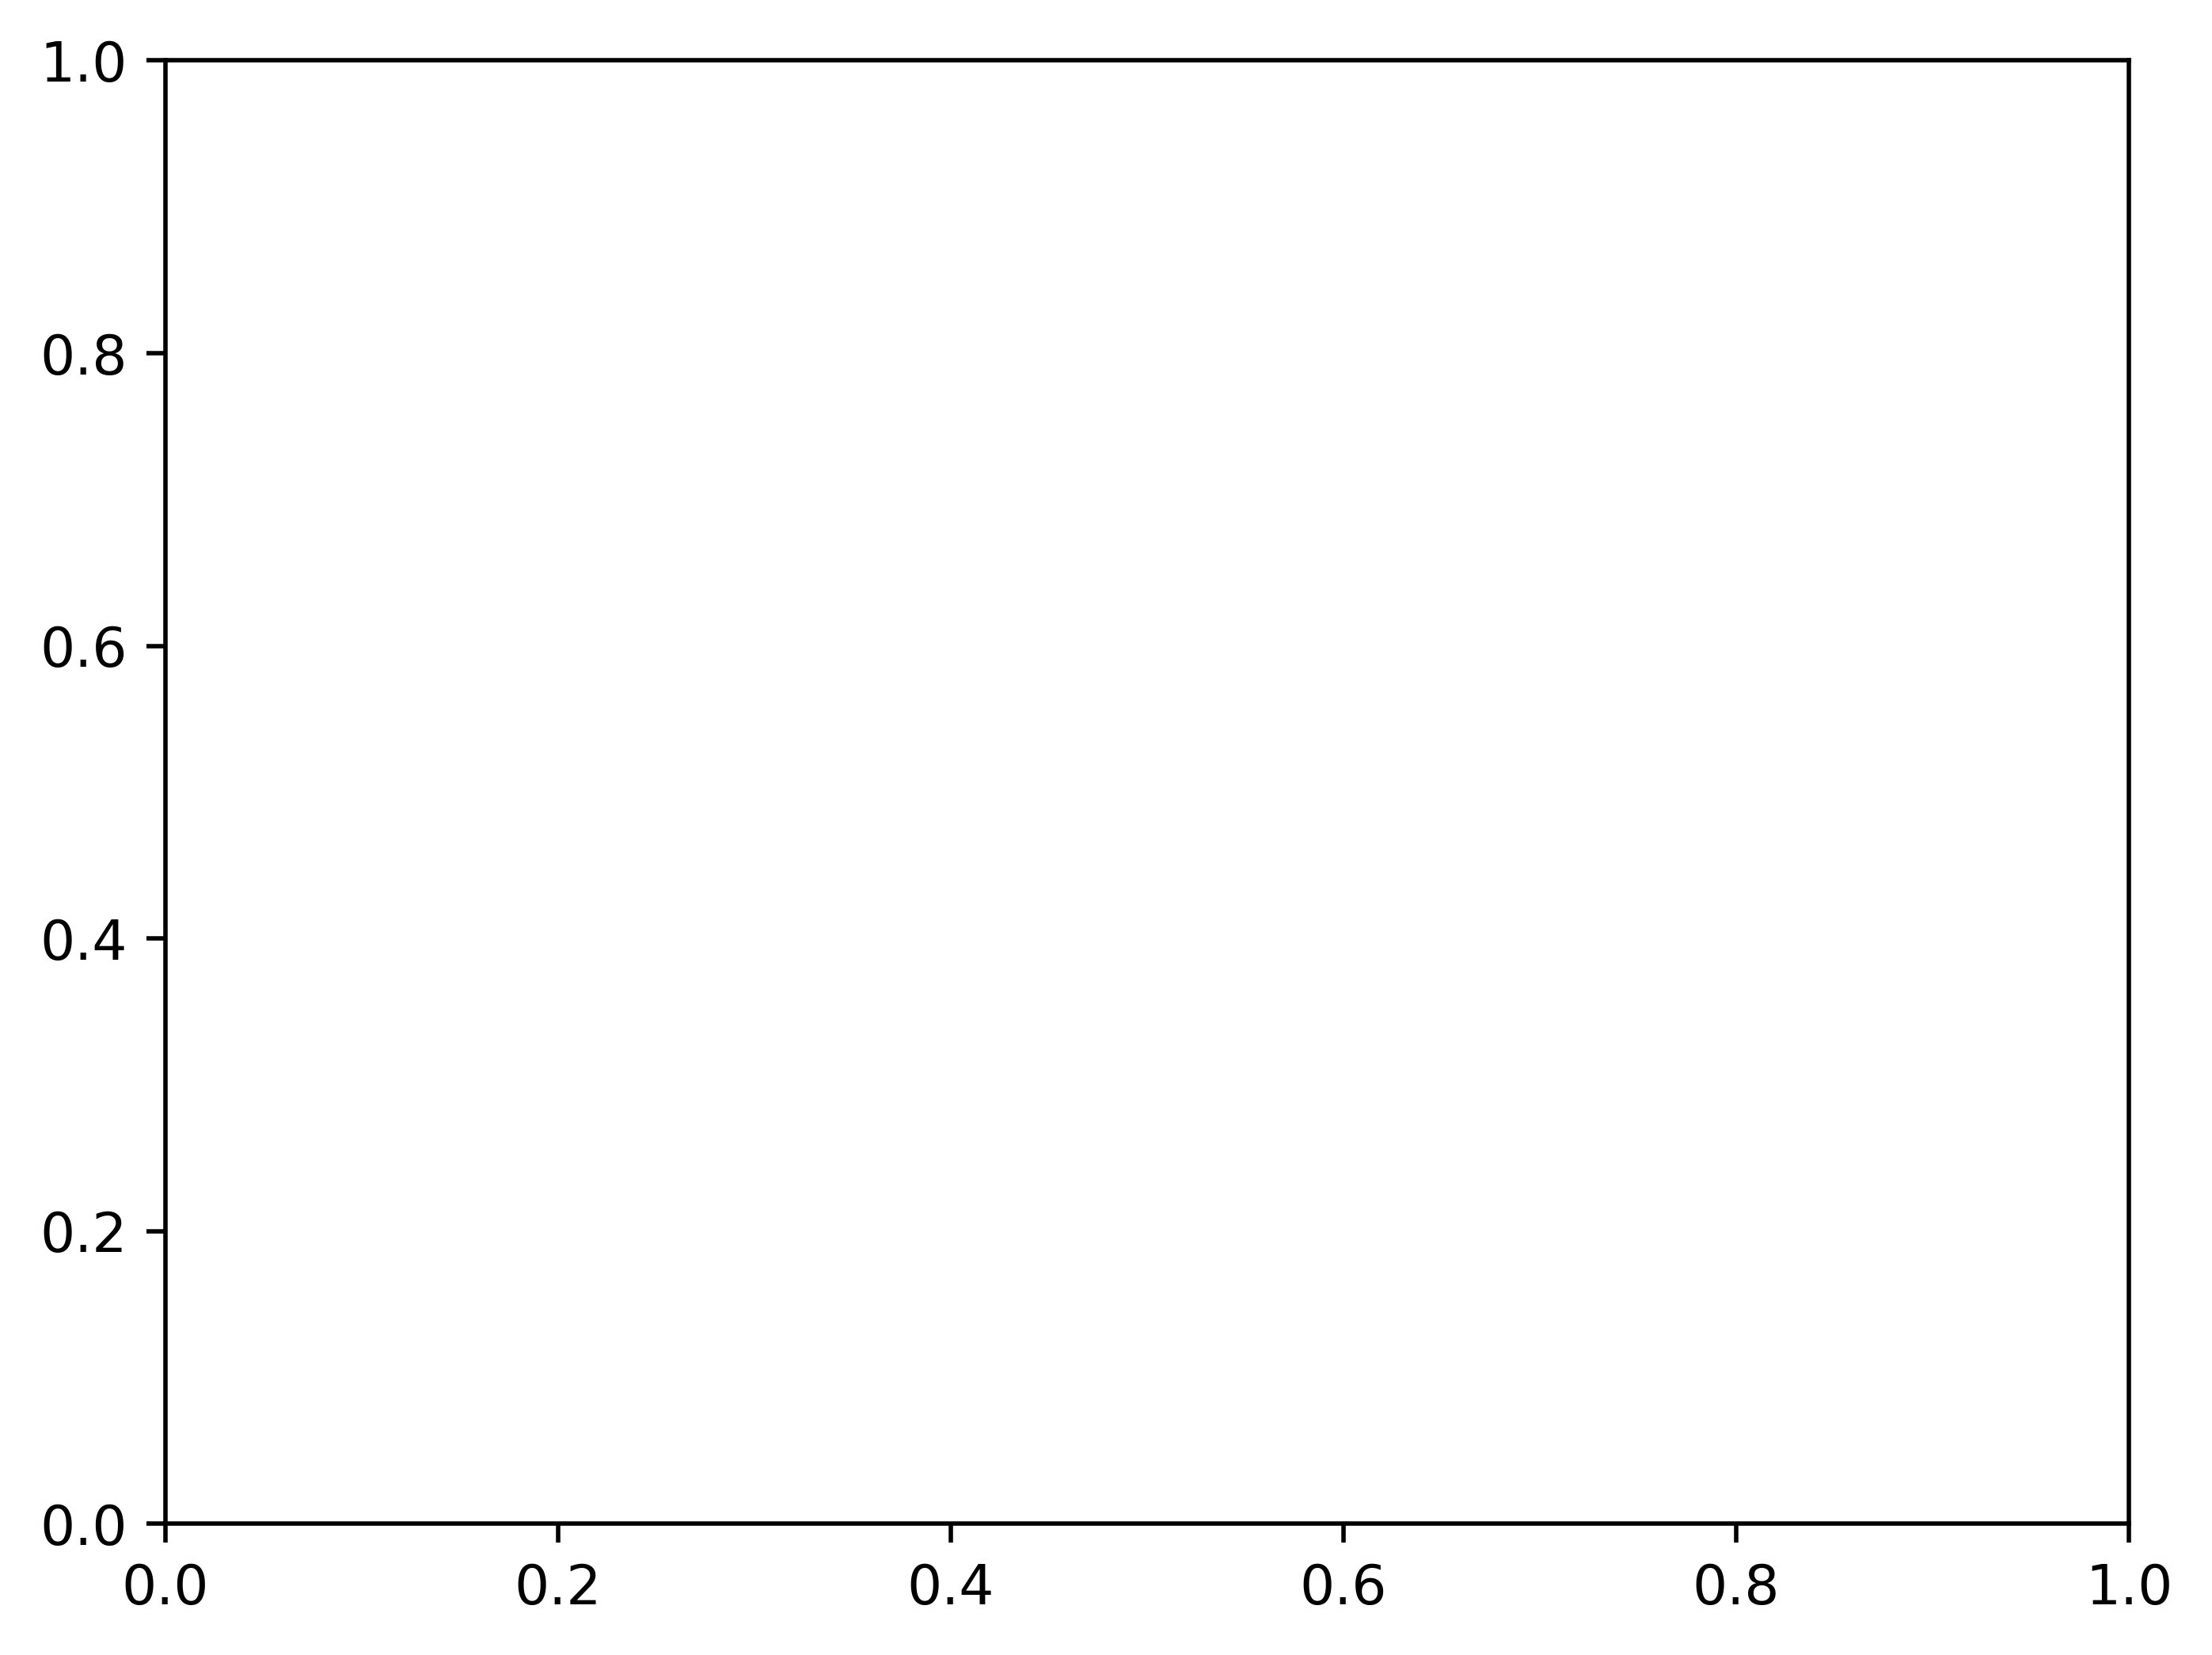

In [145]:
plt.figure(dpi=500)
# plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,K_est,color='blue',lw=3)
plt.axhline(K,color='black',ls='--',label=r'True ${K}$')
plt.ylim(0,K+1)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,t.max())
plt.legend()

plt.twinx()
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,R_pred,color='green',lw=3)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:

var currentPage = nowPageNum;
function goNextPage() {
    if (currentPage < totalPageNum) {
        opener.PageMove(currentPage);
        console.log(`${currentPage} 페이지를 수강완료했습니다.`);
        currentPage += 1;
        setTimeout(function () {
            goNextPage();
        }, 100);
    } else {
        opener.PageMove(currentPage);
        console.log('강의 수강이 완료되었습니다!');
        setTimeout(function () {
            window.close();
        }, 200);
    }
}
setTimeout(function () {
    goNextPage();
}, 100)

/* 
[퀴즈 스킵]
1. 6과목을 다 듣고 '평가하기' 버튼을 누른다.
2. 개발자도구(F12 버튼을 눌러)를 열어 'console' 탭에 이동해 아래 스크립트를 붙여넣는다.